In [1]:
#comparacion por regiones

In [17]:
import psycopg2
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib notebook

def promedio(espectro, nfft):
    """ Realiza promedios del espectro,
    debido a que las muestras estan almacenadas en un vector de tamano N
    que se subdivide N/nfft veces y ese es el numero que se promedia (K)"""
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x   

In [2]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

# seleccion de regiones

In [3]:
query_region = []
query_region.append("SELECT id, zona FROM radioastronomia_regioncampana;")
query_region = "".join(query_region)

In [4]:
print(query_region)

SELECT id, zona FROM radioastronomia_regioncampana;


In [5]:
cur.execute(query_region)
rows = cur.fetchall()

ids = rows
print(ids)
print(rows)

[(17, 'Testing'), (18, 'Testing2'), (19, 'Testing4'), (21, '3Testing'), (22, '3Testing1'), (23, '3Testing5'), (24, 'Thania')]
[(17, 'Testing'), (18, 'Testing2'), (19, 'Testing4'), (21, '3Testing'), (22, '3Testing1'), (23, '3Testing5'), (24, 'Thania')]


# Seleccion de frecuencia central

In [6]:
query_freq = []
query_freq.append("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
query_freq = "".join(query_freq)
print(query_freq)

SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;


In [8]:
cur.execute(query_freq)
frec_central = cur.fetchall()
print(frec_central)

[(70000000.0,), (74000000.0,), (78000000.0,), (82000000.0,), (86000000.0,), (90000000.0,), (94000000.0,), (98000000.0,), (102000000.0,), (106000000.0,)]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


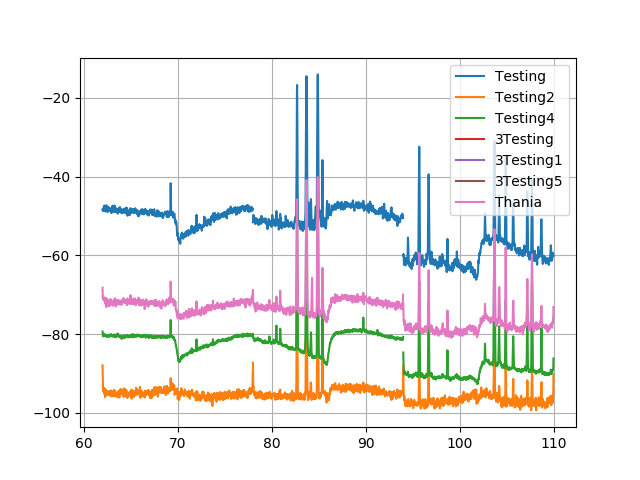

In [18]:
columns = ["ener", "media", "mediana", "std", "max", "min", "target"] 
df = pd.DataFrame(columns=columns)
df1 = pd.DataFrame(columns=["media", "energia", "target"])
k = 0
l = 0
for i in ids:
    y = numpy.array([])
    freq = numpy.array([])
    for frec_cen in frec_central:
        query_espectro = "SELECT espectro FROM radioastronomia_espectro WHERE frec_central = %s AND region_id = %s AND frec_muestreo= %s"
        cur.execute(query_espectro, [frec_cen[0], i[0], 16000000])
        rows = cur.fetchall()
        
        x_ = numpy.zeros(1024)
        for row in rows:
            espectro = row[0]
            espectro = numpy.asarray(espectro)
            x = promedio(espectro, 1024)
            x_ = x_ + x
            ener_ = numpy.sum(10**(x_/10))
            media_ = numpy.mean(10**(x_/10))
            mediana_ = numpy.median(10**(x_/10))
            std_ =  numpy.std(10**(x_/10))
            max_ = numpy.max(10**(x_/10))
            min_ =  numpy.min(10**(x_/10))
            df.loc[k] = [ener_, media_, mediana_, std_, max_, min_,i[0]]
            k+=1
        x_ = x_/len(rows)

    
        freq = numpy.append(freq, numpy.arange(-int(1024/2),int(1024/2),1)*16000000/1024 + frec_cen[0])
        y = numpy.append(y,x_)
    plt.plot(freq/1e6, y, label=i[1])
    plt.legend()
    plt.grid(True)
    y = 10**(y/10)
    df1.loc[l] = [10*numpy.log10(numpy.mean(y)), 10*numpy.log10(numpy.sum(y)), i[0]]
    l+=1

   media  energia  target
0    NaN      NaN    17.0
1    NaN      NaN    18.0
2    NaN      NaN    19.0
3    NaN      NaN    21.0
4    NaN      NaN    22.0


<IPython.core.display.Javascript object>


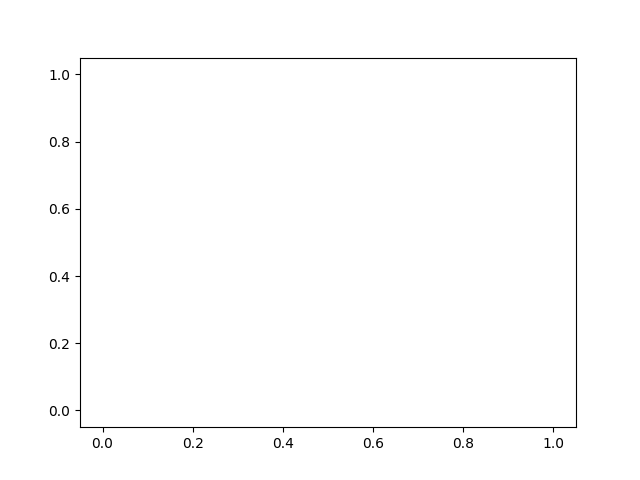

/home/uis-e3t/.local/lib/python3.6/site-packages/matplotlib/transforms.py:918: UserWarning: Warning: converting a masked element to nan.
  self._points[:, 0] = interval
/home/uis-e3t/.local/lib/python3.6/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/uis-e3t/.local/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
/home/uis-e3t/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


ValueError: cannot convert float NaN to integer

In [19]:
print(df1.head())
fig, ax = plt.subplots()
scatter = ax.scatter(df1["media"], df1["energia"], c=df1["target"])

#plt.scatter(df1["media"], df1["energia"], c=df1["target"])

legend1 = ax.legend(*scatter.legend_elements(), title="Lugares")
ax.add_artist(legend1)

plt.xlabel("Media")
plt.ylabel("Energia")
plt.grid(True)
plt.legend()

# Caracteristicas para comparacion de zonas

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 7 columns):
ener       106 non-null float64
media      106 non-null float64
mediana    106 non-null float64
std        106 non-null float64
max        106 non-null float64
min        106 non-null float64
target     106 non-null float64
dtypes: float64(7)
memory usage: 6.6 KB


In [21]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

<IPython.core.display.Javascript object>


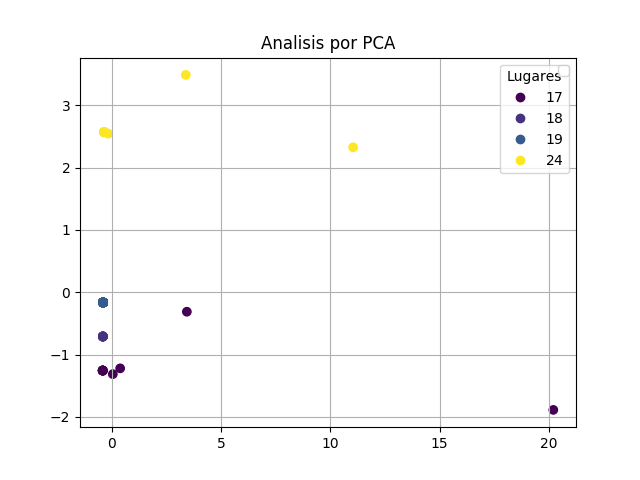

No handles with labels found to put in legend.


In [22]:
fig, ax = plt.subplots()
scatter = ax.scatter(x_pca[:,0], x_pca[:,1], c=df["target"])

#plt.scatter(df1["media"], df1["energia"], c=df1["target"])
legend = ax.legend(*scatter.legend_elements(), title="Lugares")
ax.add_artist(legend)

plt.grid(True)
plt.title("Analisis por PCA")
plt.legend()

In [23]:
conn.close()